# **Tutorial 2: Demand prediction of bike sharing system**
Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues. 

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important events in the city could be detected via monitoring these data.

## Load data 
Details at https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset

In [1]:
import pandas as pd

#url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/Exercise_2_regression_model/Exercise2BikeSharing.csv'
#df = pd.read_csv(url)

df = pd.read_csv('Exercise2BikeSharing.csv')
df.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


In [2]:
df.shape

(17379, 17)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


## Feature engineering
- Target: `cnt` (count of total rental bikes including both casual and registered)
- Predictors: weather (`temp`, `atemp`, `hum`, `windspeed`, `weathersit`), calendar (`hr`, `weekday`, `workingday`, `holiday`, `season`), and `yr`.
- We keep it simple; you can expand features (e.g., interactions) later.

In [4]:
from sklearn.model_selection import train_test_split
target = 'cnt'
features = [
    'temp','atemp','hum','windspeed','weathersit',
    'hr','weekday','workingday','holiday','season','yr'
]

X = df[features].copy()
y = df[target].astype(float)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


## Normalization
Normalization is essential, especially when using SVMs, as it's sensitive to the scale of features. We can use StandardScaler from scikit-learn to normalize the data. It transforms the data so that each feature has a mean of 0 and a standard deviation of 1, which can be important for certain algorithms that are sensitive to the scale of input features, like gradient descent-based optimization methods. Other scalers include Min-Max scaling ("MinMaxScaler"), which scales features to a specific range (typically [0, 1]), and Robust scaling ("RobustScaler"), which is less affected by outliers in the data compared to StandardScaler. These scalers are used to preprocess data and make it more suitable for machine learning algorithms.

It is important to fit the scaler on the training data only and afterwards apply the fitted scaler to the test data. When fitting the scaler on both the train and test data there might be unwanted information leackage. 

In [5]:
from sklearn.preprocessing import StandardScaler

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Grid search
Hyperparameter tuning helps find the best set of hyperparameters for your model. We'll use GridSearchCV from scikit-learn to search for the best combination of parameters. Grid search is a hyperparameter tuning technique in machine learning used to systematically search through a predefined set of hyperparameter combinations for a given model to identify the best-performing configuration. It automates the process of selecting the optimal hyperparameters, helping improve the model's performance and generalization on unseen data by finding the best parameter values that minimize errors or maximize a chosen performance metric.

The GridSearchCV applies for each parameter set a cross validation (in this case five splits). By executing this cross validation we can increase the robustness of the results.

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'kernel': ['linear',  'rbf'],
    'C': [ 1, 10],
    'epsilon': [ 1, 10]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(SVR(), param_grid, cv=5, verbose=2)

# Fit the grid search to the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print("Best Parameters:", best_params)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END .................C=0.1, epsilon=0.01, kernel=linear; total time=   3.6s
[CV] END .................C=0.1, epsilon=0.01, kernel=linear; total time=   3.5s
[CV] END .................C=0.1, epsilon=0.01, kernel=linear; total time=   3.5s
[CV] END .................C=0.1, epsilon=0.01, kernel=linear; total time=   3.5s
[CV] END .................C=0.1, epsilon=0.01, kernel=linear; total time=   3.5s
[CV] END ...................C=0.1, epsilon=0.01, kernel=poly; total time=   4.0s
[CV] END ...................C=0.1, epsilon=0.01, kernel=poly; total time=   4.0s
[CV] END ...................C=0.1, epsilon=0.01, kernel=poly; total time=   4.0s
[CV] END ...................C=0.1, epsilon=0.01, kernel=poly; total time=   4.0s
[CV] END ...................C=0.1, epsilon=0.01, kernel=poly; total time=   4.0s
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time=   6.3s
[CV] END ....................C=0.1, epsilon=0.0

## Train a SVM regression model
Now, create an SVM regression model using the best parameters and train it using the training data.

In [7]:
# Create an SVR model with the best parameters from the grid search
best_svr = SVR(kernel=best_params['kernel'], C=best_params['C'], epsilon=best_params['epsilon'])
best_svr.fit(X_train, y_train)


SVR(C=10, epsilon=10)

## Make predictions
Use the trained model to make predictions on the test data and evaluate the performance of the SVM regression model using metrics like Mean Squared Error (MSE) and R-squared.

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = best_svr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 79.97929783472865
Mean Squared Error: 16547.571712068588
R-squared: 0.4774243878835329


## Let's see the predictions
we create a "Actual vs. Predicted Values" graph again to give a visual inspection of the prediction quality.

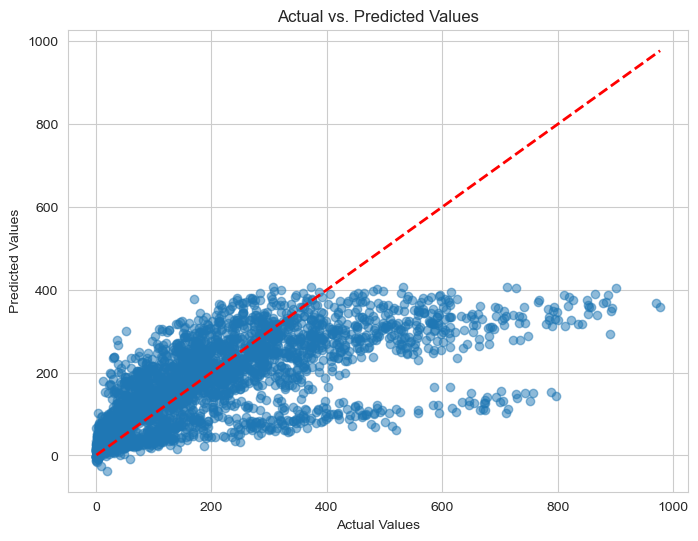

In [11]:
# y_test contains the actual target values for the test dataset
# y_pred contains the predicted values for the test dataset

# Create a scatter plot to visualize the relationship
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()